In [1]:
import numpy as np
import random

T = 1000
x_max = 10
# P(D=1) distribution
Pd = [i/1000 for i in range(T + 1)]
# holding cost
h = 0.01
# purchase cost
c = 10
# selling price
p = 20
# order cost
K = 10

V = np.array([[float(0) for i in range(T + 1)] for j in range(x_max + 1)])
alpha = np.array([[float(0)for i in range(T + 1)] for j in range(x_max + 1)])

# initialized the last column: hx
V[:, -1] = [x * h for x in range(0, x_max + 1)] 


for t in range(T - 1, 0, -1):
    if t > 900:
        c = 0
    elif t > 500 and t <= 900:
        c = 15
    else: 
        c = 10

    dIsOne = Pd[t]
    dIsZero = round(1 - dIsOne, 3)
    # P(d=1) increases linearly as t increases
    d = random.choices([1, 0], weights=(dIsOne, dIsZero), k = 1)[0]
    
    if t > 900:
        # At t > 900 no order can be placed, so the optimal policy would be just a copy of optimal policy at t = 900
        for x in range(0, x_max):
            Q = {}
            E = dIsOne * V[x - 1][t + 1] + dIsZero * V[x - 0][t + 1]  
            
            # items can only be sold
            V[x][t] = (-h * x)  + dIsOne * p + E

            # optimal policy remains unchanged after t = 900
            alpha[x][t]= alpha[x][t+1]

    # when  t <= 900
    else: 
        for x in range(0, x_max):
            Q = {}
            for a in range(max(d-x,0) , x_max - x + d):
                E = dIsOne * V[x - 1 + a][t + 1] + dIsZero * V[x - 0 + a][t + 1]
                order_cost = K if a > 0 else 0    
                Q[a] = (-h * x) - order_cost - (c * a)  + dIsOne * p + E
            V[x][t] = Q[max(d-x, 0)]
            alpha[x][t]= max(d-x, 0)
            for a in range(max(d-x,0), x_max-x+d):
                if(Q[a] > V[x][t]):
                    alpha[x][t]=a
                    V[x][t] = Q[a]



for i in range(x_max + 1):
    for j in range(990, T + 1):
        print(V[i][j],end=' ')
    print() 
print ('-------------------')




print('------------')

for i in range(x_max + 1):
    for j in range(990, T + 1):
        print(alpha[i][j], end = ' ')
    print()

print('------------')

for i in range(x_max + 1):
    for j in range(0, 11):
        print(V[i][j],end=' ')
    print() 

print('------------')

for i in range(x_max + 1):
    for j in range(0, 11):
        print(alpha[i][j], end = ' ')
    print()



20.0 20.0 20.0 20.0 20.000000000000057 20.000000000009585 20.000000001917602 20.0000004794 20.000159800000002 20.079900000000002 0.0 
39.9898990927493 39.98990927492961 39.98991943662314 39.98992957789211 39.9899396988651 39.989949809262654 39.98996147092744 39.99024836126 40.02968022 19.97001 0.01 
59.96970756296519 59.96973807848762 59.9697685326766 59.96979892595354 59.96982928292809 59.96986208683606 59.97008465265232 59.949321209340006 39.91001 19.970010000000002 0.02 
79.93943566403482 79.93949663320629 79.93955748042059 79.93961823433423 79.93967948380671 79.93942824861156 79.83880384450265 59.81998 39.90001 19.97001 0.03 
99.89909361818023 99.89919513059941 99.89929638917768 99.89938758976558 99.89798033507157 99.69810932528013 79.6999 59.799980000000005 39.890010000000004 19.970010000000002 0.04 
119.84869161251139 119.848843321797 119.84895556910274 119.84538500691136 119.52721916932843 99.54974999999999 79.66990000000001 59.77998 39.88001 19.97001 0.05 
139.7882383490452 139


### Choose appropriate X and A  use dynamic programming (programmed in 
python) to determine the total expected profit and the optimal order policy, 
starting with 0 inventory at time 0

- X(state) is  the current number of items in inventory max value of which can be
     x_max(currently 10 is used for simplicity of understanding) - current level + demand
- A(action) is placing an order 

### Part B

In [15]:
import matplotlib.pyplot as plt

def plotter(Z, T, S, title):
    x = np.arange(0,T+1)
    y = np.arange(0,S+1)
    X,Y = np.meshgrid(x, y)
    fig = plt.figure(figsize=(7, 4), dpi=80)
    ax = fig.add_subplot(111)
    contour = ax.contourf(X, Y, Z, 20)
    fig.colorbar(contour)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("InventoryLevel", fontsize=12)
    plt.title(title, fontsize=14)
    plt.show()

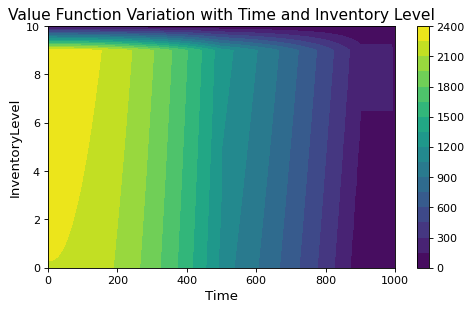

In [16]:
plotter(V, T, x_max, "Value Function Variation with Time and Inventory Level")